<a id='Top'></a>
# Deep Neural Networks - Part 1: Naïve and Feed-forward

### Table of Contents:

1. **[Introduction](#introduction)**
    + Data Overview and Preprocessing
    + Common-sense Baseline
    
    
2. **[Methodology](#initial-discovery)** 
    + MVP for Beating Baseline
    + Optimisation
    + Hyperparameter Tuning
    + Regularisation


3. **[Results](#analysis)**
    + Recalculating Optimal Epochs
    + Full Training and Evaluation
    + Segmented Evaluation with Baselines


4. **[Conclusions and Discussion](#interpretation)**
    + Discussion
    + Limitations and Further Investigation
    + Summary
    + References

In [1]:
import datetime
import json
import os
import random
import re
from math import ceil
from typing import List, Optional
from copy import deepcopy as dc

import jsonlines
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output
from keras import layers, models, regularizers
from keras.engine.sequential import Sequential  # for type hints
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import \
    MultiLabelBinarizer, StandardScaler  # for encoding from raw data and standisation

# nltk deps
cwd = os.getcwd() # so we can save locally as well to access tagset docs
nltk.download("tagsets", download_dir=cwd)
nltk.download("tagsets")
nltk.download("averaged_perceptron_tagger")
nltk.download("punkt")

[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/sheplecjs/Desktop/DSM150/CW_sentences...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/sheplecjs/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sheplecjs/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/sheplecjs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<a id='introduction'></a>
### Introduction
[Back to top](#Top)

Product reviews in e-commerce are frequently used by consumers to inform purchase decisions. Exploration of approaches to mining and modeling product reviews for usefulness in purchase decision-making has enjoyed a significant amount of research interest in recent years. In a 2018 review, Diaz and Ng provide a summary of results from an array of approaches, including a discussion of features and architectures used (Diaz & Ng, 2018). Notable early work on the problem focused on review length features and word-category features, chiefly modeled using Scalable Vector Machine models (Kim et. al. 2006). Subsequently, this body of work has begun to address some critical questions on the topic including refining operational definitions of usefulness and how best to extract features from review text that will be relevant to these.

In a recent study Gamzu et.al. contribute a novel take on the problem and address it with a unique dataset (Gamzu et. al. 2021). In their work, individual sentences from reviews are human-tagged for usefulness in purchase decision making. This focus on sentence-level data is aimed at a solution to automatic review helpfulness scoring that will produce quality and representative review data for consumers shopping via channels that have limited real estate in comparison to full-screened devices (namely phones and voice-mediated interaction e.g. Amazon Alexa), such that reading (or hearing read) a review in its entirety would be awkward or time consuming. A critical initial step in their proposed process is vectorisation and prediction of review sentence helpfulness.

In this investigation, we will utilize the dataset developed by Gamzu et. al. in an attempt to produce and tune a low-capacity, yet performant feed-forward neural network predictive of review sentence helpfulness. In contrast to the approach presented in Gamzu et. al. which is optimized for overall accuracy, sentences here are vectorised using one-hot encoded part-of-speech tagging in order to create a low-dimensional representation describing the presence or absence of syntactic tokens. While previous work found syntactic tokens did not make an effective content feature for helpfulness score prediction, these studies utilized reviews in their entirety (Kim et. al 2006). While it stands to reason that paragraph-length reviews might produce noisy vectors profiling syntactic content, shorter sentence-level vectorisation may provide enough in the way of distinguishing features to serve as a basis for differentiation. 

A common-sense baseline is established by rescaling the count of distinct syntactic tags in sentences to helpfulness scores, expanding on an established statistical relationship between helpfulness and review word count (Mudambi & Schuff, 2010). In effect, this approximates the complexity of a sentence via the number of distinct types of words it contains. A simple neural network is then deployed which performs better than the baseline (using hold-out validation of 15% of the training set). This network is then expanded and tuned using a heuristic search approach to include an optimal number and type of hidden layers, node density, learning rate, and training epochs (given reasonable constraints). Regularisation is then tested and applied to the best performing model. The performance of the baseline and final tuned model are detailed and results are discussed in terms of mean absolute error overall and segmented by helpfulness quartiles.

#### Data Overview and Preprocessing

The dataset used in this analysis is published under the CDLA-sharing license and is split between training (20000 records) and test data (2000 records). It is published in the [Registry of Open Data on AWS](https://registry.opendata.aws), and may be accessed from the link below or via the AWS CLI or a software SDK. Code is provided to facilitate recreation of data directory and programatic data download with the AWS CLI. Raw data is stored in the jsonlines format, which are parsed into dataframes. To be made ready for use, relevant data are then encoded using a multi-label binarizer applied to a part-of-speech tagged tokenized sentences.

+ [Link to original data](https://registry.opendata.aws/helpful-sentences-from-reviews/)
+ [CDLA-Sharing license](https://cdla.dev/sharing-1-0/)

The data as a whole consist of an item identification number ("asin" for a total of 123 different products across various categories), the text of the sentence in question, a helpfulness score, a url to an image of the product, and the full product name. The helpfulness score is an average of human tagged scores based on a scale of 0-2 (0 meaning not at all useful, 1 corresponding to somewhat useful, and 2 meaning very useful). Gamzu et. al. include a detailed discussion of the reliability of these data despite what appears to be a somewhat subjective measure of helpfulness. In short, inter-annotator agreement is aligned with best practices in the field (Gamzu et.al. 2021).

In [2]:
# recreate our dir structure
try:
    os.mkdir("data")
    
except FileExistsError:
    print("Data directory already exists")

# download data (requires aws CLI)
!aws s3 cp s3://helpful-sentences-from-reviews/train.json data/ --no-sign-request
!aws s3 cp s3://helpful-sentences-from-reviews/test.json data/ --no-sign-request

Data directory already exists
download: s3://helpful-sentences-from-reviews/train.json to data/train.json
download: s3://helpful-sentences-from-reviews/test.json to data/test.json


In [3]:
# read these jsonlines files into train and test arrays
raw_train = []
raw_test = []

with jsonlines.open("data/train.json") as reader:
    for obj in reader:
        raw_train.append(obj)

with jsonlines.open("data/test.json") as reader:
    for obj in reader:
        raw_test.append(obj)

In [4]:
df = pd.DataFrame(raw_train)
df_test = pd.DataFrame(raw_test)

In [5]:
df.head()

,asin,sentence,helpful,main_image_url,product_title
0,B000AO3L84,this flash is a superb value.,1.70,http://ecx.images-amazon.com/images/I/41XAEKR9...,Canon 430EX Speedlite Flash for Canon EOS SLR ...
1,B001SEQPGK,The pictures were not sharp at all.,1.30,http://ecx.images-amazon.com/images/I/71KLvmtc...,Sony Cyber-shot DSC-W290 12 MP Digital Camera ...
2,0553386697,A very good resource for parents.,1.90,http://ecx.images-amazon.com/images/I/81HdbmkR...,The Whole-Brain Child: 12 Revolutionary Strate...
3,B006SUWZH2,"We have it in a child's room, and will be swit...",0.25,http://ecx.images-amazon.com/images/I/61A2WQOL...,Memorex Portable CD Boombox with AM FM Radio
4,B000W7F5SS,Again the makers are too lazy to bring in the ...,0.90,http://ecx.images-amazon.com/images/I/91E7TPDb...,Harry Potter and the Order of the Phoenix (Wid...


In [6]:
# we'll need the complete list of pos tags in order to set the dimensions for our vectors
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

In [7]:
# nltk.help.upenn_tagset() - this just stdouts it, need to grab it from the file manually
with open("help/tagsets/upenn_tagset.pickle") as d:
    docs = d.read()

# tag labels are contained within these regex every 7th line
headings = r"^S'|^sS'|^sS\"|'$|\"$"

all_pos_tags = [
    re.sub(headings, "", t).replace('"', "") for t in docs.split("\n")[1::7]
]

In [8]:
def pos_vectorize_sentences(sentences: pd.Series, tags: List) -> pd.DataFrame:
    """A func that takes a Series of sentences and a list of tags and transforms 
    it into an encoded matrix.

    Args:
        sentences (pd.Series): Sentences to vectorize.
        tags (List): Tag labels to use as encoded classes.

    Returns:
        pd.DataFrame: A dataframe containing the encoded matrix of sentences.
    """
    
    # regex to remove numbers
    number_re = r"[0-9#]*"
    sentences = [re.sub(number_re, "", s) for s in sentences]
    
    # tokenize raw sentences and convert to pos tagged
    tagged = [
        nltk.pos_tag(nltk.tokenize.word_tokenize(s, language="english"))
        for s in sentences
    ]

    all_str = []

    # append tag strings discarding the actual word
    for sentence in tagged:
        sentence_str = []
        for token in sentence:
            sentence_str.append(token[1])
        all_str.append(sentence_str)
    
    # one-hot encode sentences
    multi_label = MultiLabelBinarizer(classes=tags)
    df_pos = pd.DataFrame(
        multi_label.fit_transform(all_str), columns=multi_label.classes_
    )
    
    return df_pos

In [9]:
df_pos = pos_vectorize_sentences(df["sentence"], all_pos_tags)
df_pos_test = pos_vectorize_sentences(df_test["sentence"], all_pos_tags)

In [10]:
df_pos.head()

,PRP$,VBG,FW,VB,POS,'',VBP,VBN,JJ,WP,...,WP$,MD,NNPS,--,JJS,JJR,SYM,UH,WDT,s.
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
# convenience labels and drop na
train_data = df_pos.astype("float")
train_data.replace(np.nan, 0, inplace=True)
train_targets = df["helpful"].to_numpy()

test_data = df_pos_test.astype("float")
test_data.replace(np.nan, 0, inplace=True)
test_targets = df_test["helpful"].to_numpy()

#### Common-sense Baseline

*Mudambi and Schuff in a 2010 study of review helpfulness, describe a statistically significant correlation between review length and helpfulness score (Mudambi & Schuff, 2010). Building on this, we'll provide a random prediction for context then compute as a common-sense baseline the mean absolute error of predictions of helpfulness related directly to count of different tags a sentence contains. In essence, this maps sentences containing a greater variety of word types to higher helpfulness scores.*

In [12]:
# append random scores
random_prediction = []

for i in range(2000):
    random_prediction.append(random.uniform(0.0, 2.0))
    
random_mae = mean_absolute_error(random_prediction, test_targets)

In [13]:
# to scale our test data we'll need max value of word count
test_length = test_data.sum(axis=1)
standardised_length = max(test_length)

In [14]:
# sum to get word count and rescale to helpfulness score
naive_prediction = test_length.apply(lambda x: (x/standardised_length)*2.0)
naive_mae = mean_absolute_error(naive_prediction, test_targets)

In [15]:
print(
    f"""Random:  MAE = {random_mae:.3f}\n 
Naive:   MAE = {naive_mae:.2f}"""
)

Random:  MAE = 0.597
 
Naive:   MAE = 0.42


*Naive prediction based solely on count of tags improves somewhat on random guesses. In practice, considering the usefulness scale used here, a model is minimally useful to the extent it can predict if a review sentence would have a helpfulness score greater than or less than 1. While random helpfulness guesses leave us with more margin of error than not in these terms, the syntactic token count based estimate at least lowers absolute error enough to have minimal statistical power.*

<a id='initial-discovery'></a>
### Methodology
[Back to top](#Top)

Using our part-of-speech vectorized data, we will develop a minimal neural network with the aim of predicting labels with higher accuracy than our common-sense baseline. As helpfulness scores are represented in decimal numbers, this is treated as a regression task with an output layer of with a single node using a mean squared error loss function. We then test our minimal network for signs of overfitting by graphing validation mean absolute error over a large number of epochs. Examining the resulting visualisations to inform a choice of epochs to train with during hyperparameter tuning, we proceed to tune the final network using a heuristic search algorithm. This algorithm iterates over variations in the number of nodes and number of hidden layers in the network. We apply some conditional logic to exploring the possibility space of available layer architecture by enforcing some constraints on nodes and layers with the aim of increasing our chances of developing a performant network that is as lightweight as possible.

Methods for creating a network and altering its configuration are defined as reusable functions to facilitate the heuristic search. Results are held in global scope variables to allow inspection in case of manual interruption and saved to a history file at every iteration to prevent total loss in case of kernel crash.

In [16]:
# standardize data
scaler = StandardScaler()  
train_data = pd.DataFrame(scaler.fit_transform(train_data))
test_data = pd.DataFrame(scaler.transform(test_data))

In [17]:
tf.random.set_seed(22)
random.seed(22)

def build_model(network_arch: List[List], 
                l_rate: float=0.001, 
                l1_penalty: float=0.001, 
                l2_penalty: float=0.001) -> Sequential:
    """A generic function for building a Sequential model from a list describing 
    layer architecture. Allows inputs for layer type, regularisation, and learning rate.
    Implements an Adam optimizer.

    Args:
        network_arch (List[List]): A list of the number of nodes associated with 
        layers and their layer type (dense, dropout, reg_l1, reg_l2, or reg_1l_l2).
        
        l_rate (float, optional): Learning rate for the optimizer. Defaults to 0.001.

    Returns:
        Sequential: A sequential model.
    """

    # generate model
    model = models.Sequential()

    # add our layers
    for layer in network_arch:
        if layer[1] == "dense":
            model.add(layers.Dense(layer[0], activation="relu"))
        
        # for adding regularisation
        elif layer[1] == "reg_l1":
            model.add(layers.Dense(layer[0], kernel_regularizer=regularizers.l1(l1_penalty), 
                                   activation="relu"))
        elif layer[1] == "reg_l2":
            model.add(layers.Dense(layer[0], kernel_regularizer=regularizers.l2(l2_penalty), 
                                   activation="relu"))
        elif layer[1] == "reg_l1_l2":
            model.add(layers.Dense(layer[0], 
                                   kernel_regularizer=regularizers.l1_l2(l1_penalty, l2_penalty), 
                                   activation="relu"))
        
        # for adding dropout layers
        else:
            model.add(layers.Dropout(layer[0]))
    
    # adjust learning_rate of our optimizer
    opt = tf.keras.optimizers.Adam(
    learning_rate=l_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
    )
        
    # output layer for regression task
    model.add(layers.Dense(1))
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])

    return model

#### MVP for Beating Baseline

*A minimal network is trained on our features to produce a more performant regressor.*

In [18]:
# simple model that beats common-sense baseline
arch = [[2, "dense"]]
model = build_model(arch)
model.fit(train_data, train_targets, epochs=5, verbose=0, workers=8)
nn_simp = model.evaluate(test_data, test_targets)

2022-01-02 12:35:27.521443: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-02 12:35:27.836770: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


63/63 [==============================] - 0s 617us/step - loss: 0.1475 - mae: 0.3011


In [19]:
print(
    f"""Random:  MAE = {random_mae:.3f}\n 
Naive:   MAE = {naive_mae:.3f}\n
Naive NN: MAE = {nn_simp[1]:.3f}"""
)

Random:  MAE = 0.597
 
Naive:   MAE = 0.421

Naive NN: MAE = 0.301


*Our simple neural network with just one input layer and a minimal number of nodes outperforms our naive baseline.*

#### Optimisation

*We'll begin by evaluating optimal epochs by checking where our basic model encounters overfitting as demonstrated by a increase in validation MAE. As it has a significant impact on training time, we will use this to **inform** our default choice of epochs to use in hyperparameter tuning. Because we'll check again for overfitting potential later, these steps are defined as reusable functions.*

**Code for calculating and visualising validation MAE over a range of epochs is adapted from Chollet 2018 (pg. 89-90).**

In [20]:
def optimal_epochs(
    num_epochs: int,
    arch: List[List],
    data: np.ndarray,
    targets: np.ndarray,
    val_split: float = 0.15,
    l_rate: float = 0.001,
) -> tuple:
    """Fits a model given an architecture and training epochs number.
    Gives us the historical MSE and MAE useful for checking for when
    overfitting occurs.

    Args:
        num_epochs (int): Number of epochs to train with.

        arch (List[List]): A list of layers describing the network.

        data (np.ndarray): Data to train with.

        targets (np.ndarray): Targets for data.

        val_split (float, optional): Percentage used in training for
        validation set. Defaults to 0.15.

        l_rate (float, optional): Learning rate for optimizer. Defaults to 0.001.

    Returns:
        tuple: [description]
    """

    model = build_model(arch, l_rate)

    history = model.fit(
        data,
        targets,
        validation_split=val_split,
        epochs=num_epochs,
        verbose=0,
        workers=8,
        use_multiprocessing=True,
    )

    mae_history = history.history["val_mae"]
    mse_history = history.history["val_loss"]

    return (mae_history, mse_history)


def smooth_curve(points: List, factor: float = 0.9) -> List:
    """A function to smooth the curve defined by a list of
    validation mean absolute errors.

    Args:
        points (List): List of MAEs.
        factor (float, optional): Scale for smoothing. Defaults to 0.9.

    Returns:
        List: A list with smoothed points.
    """
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    
    # get the minimum value
    lowest = min(points)
    lowest_x = points.index(lowest)
    
    return smoothed_points, lowest, lowest_x


def plot_epoch_data(mae: List, mse: List, start: int=1, y_annotate_offset: float=0.00003) -> None:
    """A convenience function to plot MSE and MAE in subplots
    and annotate teh lowest MAE value. This shows where training fit happens (lowest mse),
    and where overfitting is indicated (diverging up mae).

    Args:
        mae (List): List of validation MAEs.
        mse (List): List of validation MSEs.
        start (int, optional): Start epoch for smoothed MAE plot. Defaults to 1.
        y_annotate_offset (float, optional): Offset for annotation label. Defaults tp 0.00003.
    """
    
    fitted = min(mse)
    fitted_x = mse.index(fitted)
    
    lowest = min(mae)
    lowest_x = smooth_mae_history.index(lowest)

    fig, ax = plt.subplots(1, 2, figsize=(15, 10))

    ax[0].plot(range(0, len(mse)), mse, color="tab:orange")
    ax[0].set_xlim([0, fitted_x])
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Validation MSE")
    ax[0].set_title("Validation Mean Squared Error by Epoch")

    ax[1].plot(
        range(start, len(smooth_mae_history)), smooth_mae_history[start:], color="tab:blue"
    )

    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Validation MAE")
    ax[1].plot(lowest_x, lowest, ls="", marker="o", label="points", color="tab:red")
    ax[1].annotate(
        "%s" % (lowest_x), (lowest_x + 10, lowest - y_annotate_offset), xycoords="data", color="tab:red"
    )
    ax[1].set_title("Validation Mean Absolute Error by Epoch (rescaled)")

In [21]:
# plot optimal epochs for our simple model
results = optimal_epochs(500, arch=arch, data=train_data, targets=train_targets)
smooth_mae_history, lowest, lowest_x = smooth_curve(results[0])

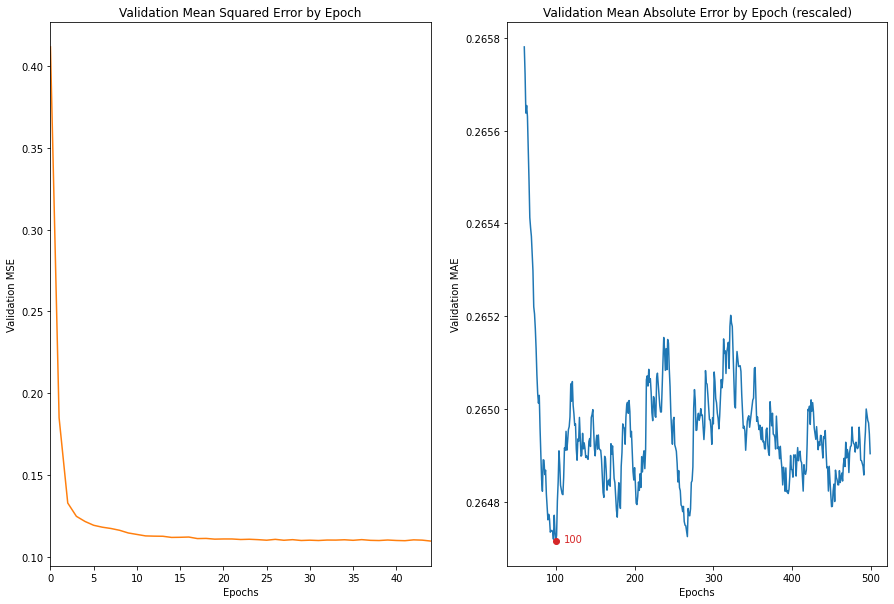

In [22]:
# run plotting in a seperate cell so we can adjust start/offset if needed
plot_epoch_data(smooth_mae_history, results[1], start=int(lowest_x * 0.75), y_annotate_offset=0.000003)

*Training data achieves fit after 40 epochs. Overfitting is indicated by diverging validation mae after 100 epochs.*

#### Hyperparameter Tuning

The following code recursively searches for the optimal configuration of nodes and hidden layers in a feed-forward neural network given a set of constraints. This tunes node density, number of layers, type of layers (dense or dropout), learning rate, and training epochs. On a broad level, this logic explores networks of increasing depth and capacity, attempting to apply time-consuming refinements on the most promising models by lowering their learning rate and increasing training epochs, while allowing some flexibility in network depth if results show signs of improvement in order to discover the best performing, lowest capacity network. Once constraints on network depth and node density are reached without signs of improvement, a new random network is initialized with a chance of including dropout layer(s) and the process proceeds again. Because random initialisation introduces a stochastic element to this search process, we provide an optional target MAE, and a maximum number of iterations to halt the search, as well as a check during random initialisation against repeating permutations. The following specific logic apply:

+ If an iteration shows the lowest MAE recorded in this run, it is rerun with a lowered learning rate (75% of previous) and more training epochs (+20%)
+ After each non-best iteration, the size of the network is increased according th the following rules and re-trained:
    1. If the last hidden layer is dense, a node is added
    2. If the last hidden layer is dropout, a new dense layer with 2 nodes is added
    3. If the last hidden layer is dense and has twice the number of nodes as its predecessor, another dense layer will be added instead of another node
    4. If the node limit is reached, another dense layer will be added
    5. If the layer limit is reached, but the MAE is improving, another node/layer will be added
    6. If the layer limit is reached, and the MAE is not improving, a random network will be generated of random length (within specified limit) and with a 33% chance of any layer being dropout
    7. If the randomly generated network has already been trained in this run, another network is generated
    
*Solution search occurs recursively until one of the following conditions is met:*

+ Max runs is met
+ A model achieves a minimum Mean Absolute Error that is lower than the target
+ Kernel failure (possibly to save a polar bear)

*In this exploration, the following constraints have been set:*

+ Training epochs is set to the lowest MAE from the simple model visualisation + 100
+ Max runs = 120
+ Target validation MAE is 0.20
+ Maximum nodes per dense layer is 40
+ The (soft) limit for input and hidden layers is 4

In [23]:
"""
Some functions for abstracting basic updates to network architechture.
These should facilitate easy adjustments to heuristic logic.
"""


def write_history(training_history: dict) -> None:
    with open("data/training_hist.json", "w") as f:
        json.dump(training_history, f)


def add_node(current_net: dict) -> dict:
    current_net["layer_nodes"][-1][0] += 1
    return current_net


def add_layer(current_net: dict) -> dict:
    current_net["layer_nodes"].append([2, "dense"])
    return current_net


def add_node_or_layer(current_net: dict, node_limit: int) -> dict:
    # most conditions return additional layer
    status = "new layer"

    # if we've hit the node limit, add a layer
    if current_net["layer_nodes"][-1][0] >= node_limit:
        current_net = add_layer(current_net)

    # if we have a dropout layer add a new dense layer
    elif current_net["layer_nodes"][-1][1] == "dropout":
        current_net = add_layer(current_net)

    else:
        try:
            # the last hidden layer twice as large as preceeding
            if (
                current_net["layer_nodes"][-1][0]
                >= current_net["layer_nodes"][-2][0] * 2
            ):
                current_net = add_layer(current_net)

            # if not, increase the size of the last hidden layer
            else:
                current_net = add_node(current_net)
                status = "new node"

        # if there are no hidden layers, add one
        except IndexError:
            current_net = add_layer(current_net)

    return current_net, status


def name_network(current_net: dict) -> str:
    net_name = "-".join([str(n) for n in [l for l in current_net["layer_nodes"]]])
    return net_name


def make_shallow(current_net: dict, layer_limit: int, training_history: dict) -> dict:
    layer_arch = []
    
    # choose a random number of layers
    layer_number = random.randint(1, layer_limit)
    
    # possible dense layers
    dense_layers = [[random.randint(2, 20), "dense"] for i in range(layer_number)]
    
    # possible dropout layers
    dropout_layers = [
        [round(random.uniform(0.1, 0.3), 2), "dropout"] for i in range(layer_number)
    ]
    
    # choose between dense and dropout and append
    for l in range(layer_number):
        layer_arch.append(
            random.choice((dense_layers[l], dense_layers[l], dropout_layers[l]))
        )

    current_net["layer_nodes"] = layer_arch
    net_name = name_network(current_net)

    status = net_name

    # check that we haven't tried this net before
    if net_name in training_history:
        make_shallow(current_net, layer_limit, training_history)

    return current_net, status

In [24]:
def heuristic_search(
    best_model: dict,
    current_net: dict,
    last_net: dict,
    training_history: dict,
    target_mae: float,
    layer_soft_limit: int,
    node_limit: int = 40,
    l_rate: float = 0.001,
    optimal_epochs: int = 17,
    status: str = "begin",
    status_list: List = [],
    max_runs: Optional[int] = 200,
) -> None:
    """A function that facilitates searching for optimal node densities number of hidden layers.
    Performance is tracked in passed variables and the training history is written to a file
    as a record and to mitigate data loss in case of a kernel crash.

    Args:
        best_model (dict): A running description of the nest performing model.

        current_net (dict): The current network being validated.

        last_net (dict): The previous network validated.

        training_history (dict): A summary of all runs.

        target_mae (float): A target mean absolute error - if reached the function ends.

        layer_soft_limit (int, optional): A soft limit for layers. If this is exceeded,
        ayers are only extended if we are experiencing a performance increase compared
        to the previous model.

        node_limit (int, optional): A limit on the number of nodes per layer.
        Defaults to 80.

        l_rate (float, optional): Learning rate for optimizer. Defaults to 0.001.

        optimal_epochs (int, optional): Number of epochs for trinaing. Defaults to 17.

        status (str, optional): A simple statement for monitoring describing last network
        adjustment.

        status_list (List, optional): A record of adjustments made to the model.
        Defaults to an empty list.

        max_runs (int, optional): A maximum number of networks to train.
        Set to None for unlimited. Defaults to 1000.

    Returns:
        None.
    """

    num_run = len(status_list)

    # unless we've opted for no limit, check for run limit
    if max_runs:
        if num_run == max_runs:
            return status_list

    # record our last change
    status_list.append(status)

    if best_model["val_mae"] < target_mae:
        return status_list

    # get layer node numbers
    layers = current_net["layer_nodes"]
    net_profile = name_network(current_net)

    # announce the current iteration profile and stats for monitoring
    print(
        f"Last MAE - {last_net['val_mae']:.3f} - Last change: {status} | Best MAE {best_model['val_mae']:.3f} |\nRun # {num_run + 1}: training for {net_profile}",
        end="\r",
        flush=True,
    )

    # construct model and fit
    model = build_model(layers, l_rate)

    hist = model.fit(
        train_data,
        train_targets,  # training data
        epochs=optimal_epochs,
        verbose=0,
        validation_split=0.15,  # validation settings
        use_multiprocessing=True,  # performance considerations
        workers=8,
    )

    validation_mae = np.min(hist.history["val_mae"])
    current_net["val_mae"] = validation_mae

    # record performance & write to file in case we lose the kernel
    training_history[net_profile] = [validation_mae]
    write_history(training_history)

    # apply best if applicable
    if validation_mae < best_model["val_mae"]:
        best_model.update(current_net)
        last_net.update(current_net)

        # lower the learning rate, add some epochs and run again
        l_rate = l_rate * 0.75
        refined_epochs = int(optimal_epochs*1.2)
        current_net["l_rate"] = l_rate
        clear_output()

        heuristic_search(
            best_model,
            current_net,
            last_net,
            training_history,
            target_mae,
            layer_soft_limit,
            l_rate,
            optimal_epochs=refined_epochs,
            status="refined learning/epochs",
            status_list=status_list,
            max_runs=max_runs
        )

    # heuristics for adjustments
    # not the best but we've hit depth limit
    if len(current_net["layer_nodes"]) > layer_soft_limit:

        # improving mae, keep going for one more
        if validation_mae < last_net["val_mae"]:

            last_net.update(current_net)
            current_net, new_status = add_node_or_layer(current_net, node_limit)
            clear_output()

            heuristic_search(
                best_model,
                current_net,
                last_net,
                training_history,
                target_mae,
                layer_soft_limit,
                optimal_epochs=optimal_epochs,
                status=new_status,
                status_list=status_list,
                max_runs=max_runs
            )

        else:
            # start with a randomized model
            last_net.update(current_net)
            current_net, new_status = make_shallow(
                current_net, layer_soft_limit, training_history
            )
            clear_output()
            heuristic_search(
                best_model,
                current_net,
                last_net,
                training_history,
                target_mae,
                layer_soft_limit,
                optimal_epochs=optimal_epochs,
                status=new_status,
                status_list=status_list,
                max_runs=max_runs
            )
    else:

        last_net.update(current_net)
        current_net, new_status = add_node_or_layer(current_net, node_limit)
        clear_output()
        heuristic_search(
            best_model,
            current_net,
            last_net,
            training_history,
            target_mae,
            layer_soft_limit,
            optimal_epochs=optimal_epochs,
            status=new_status,
            status_list=status_list,
            max_runs=max_runs
        )

In [25]:
training_history = {}
status_list = []
best_model = {"layer_nodes": [], "val_mae": 2.0, "l_rate": 0.001}

# define starting architecture here
current_net = {
    "layer_nodes": arch, # our simple network to beat baseline as a starting point
    "val_mae": lowest, # the lowest mae achieved earlier
    "l_rate": 0.001,
}

last_net = {
    "layer_nodes": [],
    "val_mae": 2.0,
    "l_rate": 0.001,
}

# MAE target to beat
target_mae = 0.20

begin = datetime.datetime.now()

# start using this target and the optimal epochs from visualisation of MAE from earlier
heuristic_search(
    best_model,
    current_net,
    last_net,
    training_history,
    target_mae,
    layer_soft_limit=4,
    optimal_epochs=lowest_x + 100,
    status="begin",
    status_list=status_list,
    max_runs=120
)

end = datetime.datetime.now()

In [26]:
# check our run time
runtime = (end - begin)
runtime.seconds

29960

In [27]:
# summarize adjustments made by the heuristic search
statuses = pd.Series(status_list)

# change specific architectures to generic labels
statuses.replace(
    to_replace=r".*dropout.*", value="net with dropout", regex=True, inplace=True
)
statuses.replace(
    to_replace=r"^\[.*", value="net without dropout", regex=True, inplace=True
)

statuses.value_counts()

new node                   82
new layer                  20
refined learning/epochs     9
net with dropout            7
begin                       1
net without dropout         1
dtype: int64

In [28]:
# describe our best model
best_model

{'layer_nodes': [[10, 'dense'],
  [0.21, 'dropout'],
  [15, 'dense'],
  [8, 'dense'],
  [3, 'dense']],
 'val_mae': 0.2618171274662018,
 'l_rate': 0.00075}

In [29]:
# define the configuration of the most accurate model
best_arch = best_model["layer_nodes"]
l_rate = best_model["l_rate"]

#### Regularisation

*We investigate the impact of various regularisation schemes, implementing kernel regularisation with a penalty of 0.001 for levels 1, 2, and 1 and 2.*

In [30]:
# make deep copys
best_arch_l1, best_arch_l2, best_arch_l1_l2 = dc(best_arch), dc(best_arch), dc(best_arch)

In [31]:
best_arch_l1[0][1] = "reg_l1"
l1 = build_model(best_arch_l1, l_rate=l_rate)
l1_hist = l1.fit(train_data, train_targets, epochs=200, verbose=0, validation_split=0.15)
l1_mae = l1_hist.history["val_mae"]

best_arch_l2[0][1] = "reg_l2"
l2 = build_model(best_arch_l2, l_rate=l_rate)
l2_hist = l2.fit(train_data, train_targets, epochs=200, verbose=0, validation_split=0.15)
l2_mae = l2_hist.history["val_mae"]

best_arch_l1_l2[0][1] = "reg_l1_l2"
l1_l2 = build_model(best_arch_l1_l2)
l1_l2_hist = l1_l2.fit(train_data, train_targets, epochs=200, verbose=0, validation_split=0.15)
l1_l2_mae = l1_l2_hist.history["val_mae"]

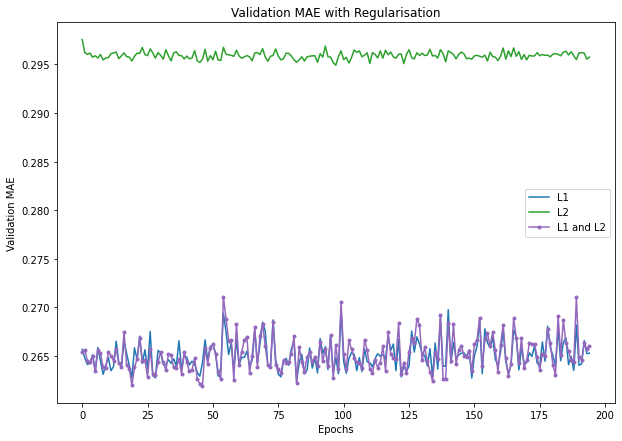

In [32]:
fig = plt.figure(figsize=(10, 7))

plt.plot(l1_mae[5:], color="tab:blue")
plt.plot(l2_mae[5:], "-", color="tab:green")
plt.plot(l1_l2_mae[5:], ".-", color="tab:purple")
plt.legend(["L1", "L2", "L1 and L2"])
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Validation MAE with Regularisation")

plt.show()

*It appears that L2 regularisation alone affects MAE significantly. We will proceed with L1 regularisation on our best model.*

<a id='analysis'></a>
### Results
[Back to top](#Top)

The result obtained by heuristic search is visualized by validation mean absolute error per epoch in order to determine where overfitting occurs in this architecture specifically. With a final training of the best model using the indicated epochs, we evaluate accuracy predicting the test set. Finally, we investigate in more detail how our tuned network and baselines perform when the test set is broken into quartiles by helpfulness score.

#### Recalculating Optimal Epochs

*We begin by recalculating the optimal epochs for training using our best model.*

In [33]:
results = optimal_epochs(
    500, arch=best_arch_l1, data=train_data, targets=train_targets, l_rate=l_rate
)
smooth_mae_history, lowest, lowest_x = smooth_curve(results[0])

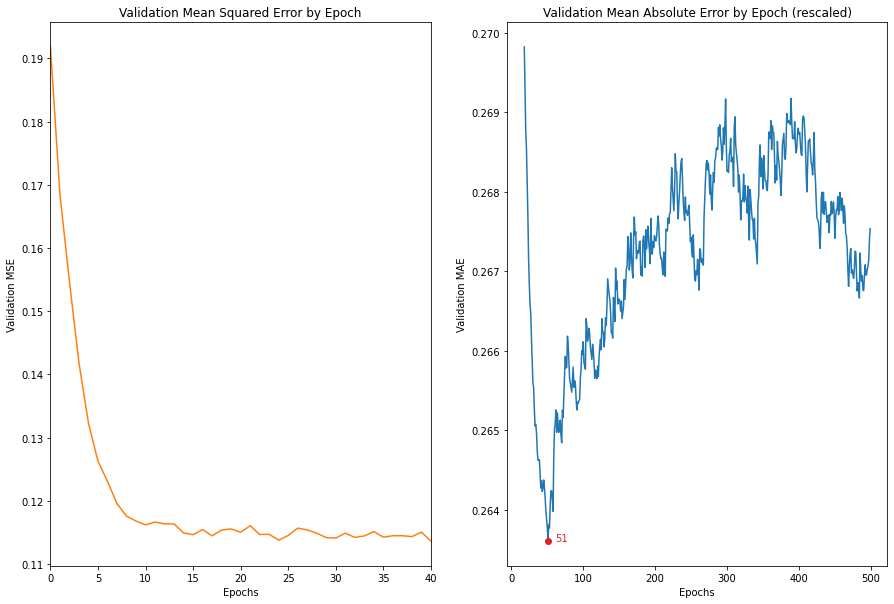

In [34]:
plot_epoch_data(smooth_mae_history, results[1], start=int(lowest_x * 0.75), y_annotate_offset=0.000003)

#### Full Training and Evaluation

*Using the updated architecture, we'll retrain the model and evaluate it against the test set.*

In [35]:
epochs = lowest_x
model = build_model(best_arch_l1, l_rate=l_rate)
history = model.fit(train_data, train_targets, 
                    epochs=51, verbose=0, 
                    use_multiprocessing=True, workers=8)

pred = model.evaluate(test_data, test_targets)

# describe final model
model.summary()

63/63 [==============================] - 0s 773us/step - loss: 0.1265 - mae: 0.2829
Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_482 (Dense)            (None, 10)                470       
_________________________________________________________________
dropout_91 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_483 (Dense)            (None, 15)                165       
_________________________________________________________________
dense_484 (Dense)            (None, 8)                 128       
_________________________________________________________________
dense_485 (Dense)            (None, 3)                 27        
_________________________________________________________________
dense_486 (Dense)            (None, 1)                 4         
Total params: 794
Trainable params

In [36]:
print(
    f"""Random:  MAE = {random_mae:.3f}\n 
Naive:   MAE = {naive_mae:.3f}\n
Naive NN: MAE = {nn_simp[1]:.3f}\n
Tuned NN: MAE = {pred[1]:.3f}"""
)

Random:  MAE = 0.597
 
Naive:   MAE = 0.421

Naive NN: MAE = 0.301

Tuned NN: MAE = 0.283


*The final tuned model builds on the speed advantage of the simple network and beats the accuracy performance of the common-sense baseline models.*

#### Segmented Evaluation with Baselines

*We break the test set into quartiles based on helpfulness score to see if there are major differences in how they evaluate different score ranges.*

In [37]:
all_test = pd.concat([df_pos_test, df_test["helpful"]], axis=1)
all_test = all_test.sort_values(by="helpful")

test_data_sorted = all_test.drop(columns=["helpful"])
test_targets_sorted = all_test["helpful"]

quartiles = []

for i in range(1, 5):
    data = test_data_sorted[500 * (i-1): 500 * i]
    targets = test_targets_sorted[500 * (i-1): 500 * i]
    center = np.mean(targets)
    
    random_prediction = []

    for i in range(500):
        random_prediction.append(random.uniform(0.0, 2.0))

    random_mae = mean_absolute_error(random_prediction, targets)
    
    data_length = data.sum(axis=1)
    naive_prediction = data_length.apply(lambda x: (x/25)*2.0)
    naive_mae = mean_absolute_error(naive_prediction, targets)
    
    pred_nn = model.evaluate(data, targets, verbose=0)
    
    quartiles.append([center, random_mae, naive_mae, pred_nn[1]])


quartile_maes = pd.DataFrame(quartiles, columns=["Avg. Helpfulness", "Random MAE", "Naive MAE", "NN_MAE"], index=["1st", "2nd", "3rd", "4th"])
quartile_maes.index.name = "Quartile"
quartile_maes.style.highlight_min(axis=1)

,Avg. Helpfulness,Random MAE,Naive MAE,NN_MAE
Quartile,,,,
1st,0.537900,0.593386,0.239540,0.705717
2nd,1.012380,0.489800,0.296100,0.267421
3rd,1.285960,0.543406,0.470480,0.069346
4th,1.574460,0.684957,0.676020,0.253146


*Our common-sense baseline appears more able to discern very low helpfulness scores, though MAE for all other quartiles is lowest for our network. Because the baseline scales directly from word count, this suggests that very low-usefulness review sentences include a significant number of the shorter sentences in this dataset.*

<a id='interpretation'></a>
### Conclusions and Discussion
[Back to top](#Top)

#### Discussion

Using a heuristic search approach to explore some possible network architectures for an optimal arrangement and employing l1 regularisation, we have developed a neural network that beats a common-sense baseline in terms of mean absolute error in predicting review sentence helpfulness using part-of-speech vectors. Hyperparameters tuned include learning rate, number of hidden layers, types of hidden layers, number of nodes, and training epochs. The final model is quite compact, consisting of only 794 trainable parameters over five layers (one dropout and four dense). Optimal network search examined 120 possible network configurations, adding layers or nodes in 102 cases, refining learning rate and training epochs in 9 cases, and initialising random networks in 8 cases.

Besides resource-low or performance-critical situations, an predictive model like this might be useful in context where text is already preprocessed and vectorised for part-of-speech (e.g. in a parallel language analysis task). Potentially included here are real-time feedback systems targeted towards improving the readability of writing which rely in part on part-of-speech analysis for other tasks (e.g. Grammarly, [Hemingway Editor](https://hemingwayapp.com), etc...). More broadly, the ability of models like this to be useful for sentence-level analysis opens the possibility of modeling of text data tagged similarly for other seemingly subjective textual characteristics like humor, sarcasm, or toxicity.

#### Limitations and Further Investigation

Some noteworthy limitations of this investigation include potential bias in the dataset. As noted by Gamzu et. al., the 123 products represented in their dataset are taken from among products offered on Amazon.com with the highest number of overall ratings. These product reviews, they note, generally have higher ratings than normal (Gamzu et. al. 2021). In practice, this means that models trained on this data are exposed to reviews of products that are reviewed at an unusually high level, so potentially non-representative of offerings generally. It's unclear if the higher volume of reviews for these products also translates into a higher or lower representation of "artificial" or fake reviews than products in general, though this certainly could be a source of problematic bias if fake reviews are distributed unevenly one way or the other. 

Because the size of training samples is relatively high (20000) given the dimensionality of representation (46 syntactic dimensions), network training here was performed using hold-out validation with a split of 15%. Because of the relatively small number of products under review however, this approach may not be optimal particularly if there is significant variation in the possible bias between a small number of products. If this is the case, defining stratified validation sets that more evenly represent the range of products reviewed might be a solution.

In addition to additional experimentation with different types of networks (other than feed-forward), vectorisation that preserves the order of syntactic tokens might also be an interesting line of investigation. This might consist of adding a tensor rank to the data structure so that the part of speech tags would "stack", in effect representing the order of parts of speech. Experimentation might also usefully reveal that some syntactic distinctions in tagging are not predictive or would be more usefully combined. For example, the tense of verbs may not be a useful factor so these categories could be combined to produce an even simpler vector. It may also be interesting to introduce feature engineering that allows for awareness of if and when a review sentence references the product by name specifically.

#### Conclusions

This exploration demonstrates that low-capacity neural network architectures can be deployed effectively in natural language processing tasks, beating a common-sense approach. Results segmented by helpfulness quartile suggest that in a production environment and with review helpfulness sentence scoring, some initial filtering of data based on word count might be beneficial (for example, discarding review sentences that are unusually short). This approach further takes advantage of sentence-level vectorisation to generate a performant low-capacity model using comparatively low-dimensional data (vs, for example, tf-idf vectors). The low MAE of our best model, particularly in estimating 3rd quartile helpfulness suggests that it is capable of reliably determining if a sentence is useful, though less adept than we might like at discerning the degree of helpfulness.

#### References

Chollet, F. (2017). Deep learning with python. New York: Manning Publications Co. LLC. Retrieved from http://ebookcentral.proquest.com/lib/londonww/detail.action?docID=6642860

Diaz, G. O., & Ng, V. Modeling and prediction of online product review helpfulness: A survey

Gamzu, I., Gonen, H., Kutiel, G., Levy, R., & Agichtein, E. (2021). Identifying helpful sentences in product reviews Association for Computational Linguistics. doi:10.18653/v1/2021.naacl-main.55

Kim, S., Pantel, P., Chklovski, T., & Pennacchiotti, M. (2006). Automatically assessing review helpfulness Association for Computational Linguistics. doi:10.3115/1610075.1610135

Mudambi, S. M., & Schuff, D. (2010). What makes a helpful online review? A study of customer reviews on amazon.com

Helpful Sentences from Reviews was accessed on 01-12-2021 from https://registry.opendata.aws/helpful-sentences-from-reviews.